In [ ]:
#API key - a7d6c9c4a6f3b3d6e8971b4c960f6165c163de514085714a5775652f679ffc66

In [ ]:
# Colab: run once
!pip install -q requests pandas tqdm matplotlib plotly seaborn nltk spacy sentence-transformers bertopic umap-learn hdbscan transformers accelerate python-dotenv
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 15.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


| Library                                 | Purpose                                                                  |
| --------------------------------------- | ------------------------------------------------------------------------ |
| **requests**                            | To call APIs like SerpAPI (HTTP requests).                               |
| **pandas**                              | For handling and analyzing tabular data (CSV, DataFrames).               |
| **tqdm**                                | For progress bars when looping through reviews.                          |
| **matplotlib**, **seaborn**, **plotly** | For creating charts and visualizations.                                  |
| **nltk**, **spacy**                     | For text preprocessing (cleaning, tokenizing, stopword removal, etc.).   |
| **sentence-transformers**               | For text embeddings (used in topic modeling).                            |
| **bertopic**                            | To discover topics (themes) in customer reviews.                         |
| **umap-learn**, **hdbscan**             | Clustering and dimensionality reduction algorithms used inside BERTopic. |
| **transformers**, **accelerate**        | For sentiment analysis and LLMs (Hugging Face models).                   |
| **python-dotenv**                       | To load API keys from `.env` files (optional).                           |
!python -m spacy download en_core_web_sm
This downloads a small English language model for SpaCy, named "en_core_web_sm".
It’s needed for text processing tasks such as:

tokenizing words/sentences,

lemmatizing (finding root forms),

part-of-speech tagging, etc.

Without it, SpaCy would show an error when you try to use it.





In [ ]:
#Imports + create outputs folder
import os, json, time, re
from getpass import getpass
import requests
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

os.makedirs("outputs", exist_ok=True)
print("Ready — outputs/ directory created")


Ready — outputs/ directory created


In [ ]:
# Enter your SerpAPI key safely
SERPAPI_KEY = getpass("Paste your SerpAPI key (from https://serpapi.com): ")

if not SERPAPI_KEY:
    raise SystemExit("SerpAPI key required. Get one at https://serpapi.com and re-run this cell.")


Paste your SerpAPI key (from https://serpapi.com): ··········


In [ ]:
#Helper functions (text cleaning, saving)
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words("english"))

def clean_text(s):
    if not isinstance(s, str): return ""
    s = s.strip()
    s = re.sub(r"http\S+", " ", s)            # remove URLs
    s = re.sub(r"@\w+", " ", s)               # remove @mentions
    s = re.sub(r"[^0-9A-Za-z\s\.\,\!\?\'\-]", " ", s)  # basic keep
    s = re.sub(r"\s+", " ", s).strip()
    return s

def save_df(df, name="reviews_clean.csv"):
    path = os.path.join("outputs", name)
    df.to_csv(path, index=False)
    print(f"Saved {path}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Get place_id from business name using SerpAPI
def get_place_id_serpapi(query, api_key):
    params = {"engine":"google_maps", "q": query, "api_key": api_key}
    r = requests.get("https://serpapi.com/search.json", params=params, timeout=30)
    r.raise_for_status()
    resp = r.json()
    # SerpAPI may return local_results or organic_results
    if 'local_results' in resp and len(resp['local_results'])>0:
        item = resp['local_results'][0]
        return item.get('place_id'), item
    # fallback: organic_results sometimes include place snippets
    if 'organic_results' in resp and len(resp['organic_results'])>0:
        for o in resp['organic_results']:
            if 'place_id' in o:
                return o['place_id'], o
    return None, resp

business = input("Enter business name + location : ").strip()
place_id, info = get_place_id_serpapi(business, SERPAPI_KEY)
if not place_id:
    print("Could not find place_id automatically. Try a different query or use Google Place ID Finder:", info)
else:
    print("Found place_id:", place_id)
    # pretty print some info if available
    try:
        print(json.dumps(info, indent=2)[:1000])
    except:
        pass


Enter business name + location : taj coramandel
Found place_id: ChIJoY2RdEJmUjoRcfpd1MDkpMI
{
  "position": 1,
  "title": "Taj Coromandel, Chennai",
  "place_id": "ChIJoY2RdEJmUjoRcfpd1MDkpMI",
  "data_id": "0x3a52664274918da1:0xc2a4e4c0d45dfa71",
  "data_cid": "14025586656386349681",
  "reviews_link": "https://serpapi.com/search.json?data_id=0x3a52664274918da1%3A0xc2a4e4c0d45dfa71&engine=google_maps_reviews&hl=en",
  "photos_link": "https://serpapi.com/search.json?data_id=0x3a52664274918da1%3A0xc2a4e4c0d45dfa71&engine=google_maps_photos&hl=en",
  "gps_coordinates": {
    "latitude": 13.058353199999999,
    "longitude": 80.2481706
  },
  "place_id_search": "https://serpapi.com/search.json?engine=google_maps&google_domain=google.com&hl=en&place_id=ChIJoY2RdEJmUjoRcfpd1MDkpMI",
  "provider_id": "/m/0hhqlnv",
  "rating": 4.6,
  "reviews": 15515,
  "price": "$83",
  "type": "Hotel",
  "types": [
    "Hotel",
    "Extended stay hotel",
    "Holiday home",
    "Resort hotel"
  ],
  "type_id"

In [ ]:
#Fetch reviews for the place_id using SerpAPI
def fetch_reviews_serpapi(place_id, api_key):
    params = {"engine":"google_maps_reviews", "place_id":place_id, "hl":"en", "api_key":api_key}
    r = requests.get("https://serpapi.com/search.json", params=params, timeout=30)
    r.raise_for_status()
    data = r.json()
    reviews = data.get("reviews", [])
    df = pd.json_normalize(reviews)
    # rename common columns
    if 'snippet' in df.columns:
        df = df.rename(columns={'snippet':'text'})
    if 'user' in df.columns and isinstance(df.loc[0,'user'], dict):
        # flatten user subfields if present
        user_df = pd.json_normalize(df['user'])
        user_df.columns = [f"user.{c}" for c in user_df.columns]
        df = pd.concat([df.drop(columns=['user']), user_df], axis=1)
    return df

if not place_id:
    raise SystemExit("No place_id. Re-run the previous cell and ensure place_id exists.")
df_raw = fetch_reviews_serpapi(place_id, SERPAPI_KEY)
print("Fetched", len(df_raw), "reviews (raw). Columns:", df_raw.columns.tolist())
df_raw.to_json("outputs/reviews_raw.json", orient="records")
df_raw.to_csv("outputs/reviews_raw.csv", index=False)
print("Saved raw reviews to outputs/")
display(df_raw)


Fetched 8 reviews (raw). Columns: ['link', 'rating', 'date', 'iso_date', 'iso_date_of_last_edit', 'source', 'review_id', 'text', 'user.name', 'user.link', 'user.contributor_id', 'user.thumbnail', 'user.local_guide', 'user.reviews', 'user.photos', 'extracted_snippet.original', 'details.trip_type', 'details.travel_group', 'details.rooms', 'details.service', 'details.location', 'details.hotel_highlights', 'images', 'response.date', 'response.iso_date', 'response.iso_date_of_last_edit', 'response.snippet', 'response.extracted_snippet.original']
Saved raw reviews to outputs/


,link,rating,date,iso_date,iso_date_of_last_edit,source,review_id,text,user.name,user.link,...,details.rooms,details.service,details.location,details.hotel_highlights,images,response.date,response.iso_date,response.iso_date_of_last_edit,response.snippet,response.extracted_snippet.original
0,https://www.google.com/maps/reviews/data=!4m8!...,5.0,a week ago,2025-10-12T15:42:02Z,2025-10-12T15:42:02Z,Google,Ci9DQUlRQUNvZENodHljRjlvT2xoclpURm1NbXRrVlRocE...,"We had an amazing stay at Taj Coromandel, Chen...",Brindha Kandhasamy,https://www.google.com/maps/contrib/1008415338...,...,5.0,5.0,5.0,Luxury,NaN,NaN,NaN,NaN,NaN,NaN
1,https://www.google.com/maps/reviews/data=!4m8!...,5.0,a week ago,2025-10-16T23:16:43Z,2025-10-16T23:16:43Z,Google,Ci9DQUlRQUNvZENodHljRjlvT2psS2QzaGhORXhqU0hSTk...,"Attended the World Bank, Chennai organized buf...",Jeffrey David,https://www.google.com/maps/contrib/1067963434...,...,5.0,3.0,3.0,NaN,[https://lh3.googleusercontent.com/geougc-cs/A...,NaN,NaN,NaN,NaN,NaN
2,https://www.tripadvisor.com/ShowUserReviews-g3...,5.0,a week ago,2025-10-17T23:59:59Z,2025-10-17T23:59:59Z,Tripadvisor,ChZDSUhNMG9nS0VPV2IwSmlzdjdleWNnEAE,I had a wonderful stay. The linen was exceptio...,RishiparnaMahanta,https://www.tripadvisor.com/ShowUserReviews-g3...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,https://www.tripadvisor.com/ShowUserReviews-g3...,5.0,a week ago,2025-10-16T23:59:59Z,2025-10-16T23:59:59Z,Tripadvisor,ChdDSUhNMG9nS0VQejlndExlbnI3azNRRRAB,Had a fantastic stay with my parents at Taj co...,587akshayr,https://www.tripadvisor.com/ShowUserReviews-g3...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://www.google.com/maps/reviews/data=!4m8!...,1.0,3 months ago,2025-07-17T06:06:41Z,2025-07-17T06:11:26Z,Google,Ci9DQUlRQUNvZENodHljRjlvT205aWRIQkRZMGxQTkhGel...,Do not stay here currently - there is very lou...,michael kerr,https://www.google.com/maps/contrib/1125593081...,...,5.0,5.0,3.0,Luxury,[https://lh3.googleusercontent.com/geougc-cs/A...,3 months ago,2025-07-24T07:51:27Z,2025-07-24T07:51:27Z,"Dear Guest,\n\nThank you for connecting with u...","Dear Guest,\n\nThank you for connecting with u..."
5,https://www.tripadvisor.com/ShowUserReviews-g3...,5.0,a week ago,2025-10-16T23:59:59Z,2025-10-16T23:59:59Z,Tripadvisor,ChdDSUhNMG9nS0VQLTI0NnkwMjlfdXNRRRAB,Hospitality is top notch!!! Thanks to Himanchu...,Pinoyvoyager,https://www.tripadvisor.com/ShowUserReviews-g3...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,https://www.tripadvisor.com/ShowUserReviews-g3...,5.0,a week ago,2025-10-17T23:59:59Z,2025-10-17T23:59:59Z,Tripadvisor,ChZDSUhNMG9nS0VKblR5ZUs4cUxyVU9nEAE,Fantastic meal at southern spice - with equall...,BeeAsh,https://www.tripadvisor.com/ShowUserReviews-g3...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,https://www.google.com/maps/reviews/data=!4m8!...,3.0,3 months ago,2025-07-18T19:47:33Z,2025-07-18T19:47:33Z,Google,Ci9DQUlRQUNvZENodHljRjlvT2pGVk4xQldORXBpWDFkWV...,Taj used to be associated with luxury. Don't g...,Omar Mohammed,https://www.google.com/maps/contrib/1071645222...,...,2.0,5.0,4.0,NaN,NaN,3 months ago,2025-07-19T07:56:36Z,2025-07-19T07:56:36Z,"Dear Guest,\n\nThank you for connecting with u...","Dear Guest,\n\nThank you for connecting with u..."


In [15]:
#Clean & standardize the reviews dataframe
df = df_raw.copy()

# find text column
text_col = None
for c in ['text','snippet','content','review']:
    if c in df.columns:
        text_col = c
        break
if text_col is None:
    # try to join text-like columns
    df['text'] = df.astype(str).agg(' '.join, axis=1)
else:
    df['text'] = df[text_col].astype(str)

# clean
df['text_clean'] = df['text'].apply(clean_text)

# rating normalization
if 'rating' not in df.columns and 'score' in df.columns:
    df['rating'] = df['score']
df['rating'] = pd.to_numeric(df.get('rating', np.nan), errors='coerce')

# date: SerpAPI often has 'time' unix timestamp
if 'time' in df.columns:
    df['date'] = pd.to_datetime(df['time'], unit='s', errors='coerce')
else:
    df['date'] = pd.NaT

# remove empty & duplicates
df = df[df['text_clean'].str.strip() != ""].drop_duplicates(subset=['text_clean']).reset_index(drop=True)
print("After cleaning, reviews:", len(df))
save_df(df, "reviews_clean.csv")
display(df[['text_clean','rating','date']].head())


After cleaning, reviews: 8
Saved outputs/reviews_clean.csv


,text_clean,rating,date
0,"We had an amazing stay at Taj Coromandel, Chen...",5.0,NaT
1,"Attended the World Bank, Chennai organized buf...",5.0,NaT
2,I had a wonderful stay. The linen was exceptio...,5.0,NaT
3,Had a fantastic stay with my parents at Taj co...,5.0,NaT
4,Do not stay here currently - there is very lou...,1.0,NaT


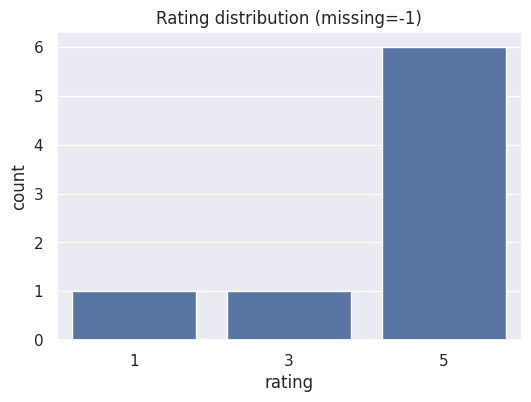


Sample positive reviews (rating>=4):


,text_clean
2,I had a wonderful stay. The linen was exceptio...
6,Fantastic meal at southern spice - with equall...
0,"We had an amazing stay at Taj Coromandel, Chen..."
3,Had a fantastic stay with my parents at Taj co...
1,"Attended the World Bank, Chennai organized buf..."


In [16]:
#Quick EDA (rating distribution, samples)
import matplotlib.pyplot as plt
import seaborn as sns

if 'rating' in df.columns and not df['rating'].isna().all():
    plt.figure(figsize=(6,4))
    sns.countplot(x=df['rating'].fillna(-1).astype(int))
    plt.title("Rating distribution (missing=-1)")
    plt.show()
else:
    print("No rating values available in this dataset.")

print("\nSample positive reviews (rating>=4):")
if 'rating' in df.columns:
    display(df[df['rating']>=4]['text_clean'].sample(min(5, len(df[df['rating']>=4]))))
else:
    display(df['text_clean'].sample(min(5,len(df))))


In [17]:
#Sentiment analysis (Hugging Face local pipeline — recommended)
from transformers import pipeline
# Use a compact model (runs on CPU)
sent_pipe = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Apply (be mindful: this may be slow for thousands of reviews)
df['hf_sentiment'] = df['text_clean'].apply(lambda x: sent_pipe(x[:512])[0]['label'])
df['hf_sentiment_score'] = df['text_clean'].apply(lambda x: sent_pipe(x[:512])[0].get('score', np.nan))
save_df(df, "reviews_with_sentiment.csv")
display(df[['text_clean','hf_sentiment']].head())


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


Saved outputs/reviews_with_sentiment.csv


,text_clean,hf_sentiment
0,"We had an amazing stay at Taj Coromandel, Chen...",POSITIVE
1,"Attended the World Bank, Chennai organized buf...",POSITIVE
2,I had a wonderful stay. The linen was exceptio...,POSITIVE
3,Had a fantastic stay with my parents at Taj co...,POSITIVE
4,Do not stay here currently - there is very lou...,NEGATIVE


Top tokens / ngrams (term, count):
taj                       8
hotel                     7
stay                      6
coromandel                5
experience                5
staff                     5
taj coromandel            5
wonderful                 5
day                       4
truly                     4
absolutely                3
beautifully               3
chennai                   3
construction              3
fantastic                 3
fresh                     3
hospitality               3
rooms                     3
service                   3
added                     2

Saved keyword counts to outputs/token_counts_small.csv


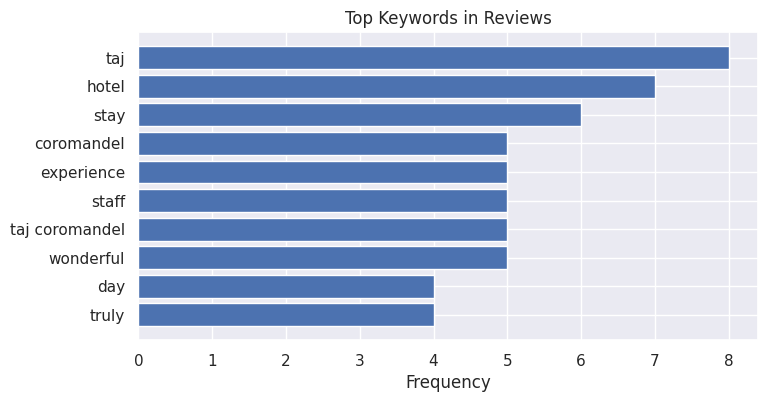

In [20]:

# ===============================
# Keyword Extraction for Small Datasets
# ===============================

from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

docs = df['text_clean'].astype(str).tolist()

vect = CountVectorizer(stop_words='english', ngram_range=(1,2), max_features=60)
X = vect.fit_transform(docs)

terms = vect.get_feature_names_out()
freqs = X.sum(axis=0).A1
pairs = sorted(list(zip(terms, freqs)), key=lambda x: x[1], reverse=True)

print("Top tokens / ngrams (term, count):")
for t, c in pairs[:20]:
    print(f"{t:<25} {c}")

# Save as CSV for record
token_df = pd.DataFrame(pairs, columns=['token','count'])
token_df.to_csv("outputs/token_counts_small.csv", index=False)
print("\nSaved keyword counts to outputs/token_counts_small.csv")

# Optional: plot top 10 keywords
import matplotlib.pyplot as plt

top_terms = token_df.head(10)
plt.figure(figsize=(8,4))
plt.barh(top_terms['token'], top_terms['count'])
plt.gca().invert_yaxis()
plt.title("Top Keywords in Reviews")
plt.xlabel("Frequency")
plt.show()


In [22]:
#Short LLM-based summary & action recommendations
OPENAI_API_KEY = None  # set if you have one; else leave None
try:
    # if you stored earlier in env, pick it up
    OPENAI_API_KEY = os.environ.get('OPENAI_API_KEY') or None
except:
    pass

reviews_list = df['text_clean'].tolist()

def llm_summary_openai(reviews_list, max_examples=20):
    import openai
    openai.api_key = OPENAI_API_KEY
    sample = "\n\n".join([f"- {r}" for r in reviews_list[:max_examples]])
    prompt = f"""
You are a helpful consultant. Given these customer reviews, produce:
1) A two-sentence summary of overall sentiment.
2) Top 3 recurring complaints (one sentence each) with an illustrative quote.
3) Top 3 concise action items for the business.

Reviews:
{sample}

Answer in numbered sections.
"""
    resp = openai.Completion.create(engine="text-davinci-003", prompt=prompt, max_tokens=400, temperature=0.2)
    return resp.choices[0].text.strip()

def heuristic_summary(reviews_list, n=5):
    # quick heuristic: most common words in negative reviews and sample quotes
    from collections import Counter
    low = [r for r in reviews_list if any(w in r.lower() for w in ["bad","slow","wait","poor","rude","dirty","broken","expensive","cold","cold food","not"])]
    cnt = Counter(" ".join(low).lower().split())
    common = [w for w, c in cnt.most_common(8) if w not in STOPWORDS]
    summary = "Summary: Reviews show recurring mentions of: " + ", ".join(common[:5]) + "."
    sample_quotes = low[:3] if low else reviews_list[:3]
    recs = ["Improve staff training", "Reduce wait times", "Address cleanliness or maintenance issues"]
    out = summary + "\n\nSample quotes:\n" + "\n".join(sample_quotes[:3]) + "\n\nRecommendations:\n" + "\n".join(recs)
    return out

if OPENAI_API_KEY:
    print("Generating OpenAI LLM summary (cost may apply)...")
    os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
    summary_text = llm_summary_openai(reviews_list, max_examples=20)
else:
    print("No OpenAI key detected — using a quick heuristic summary (fast, free).")
    summary_text = heuristic_summary(reviews_list, n=5)

print("\n=== Summary & Recommendations ===\n")
print(summary_text)
with open("outputs/llm_summary.txt", "w") as fh:
    fh.write(summary_text)
print("\nSaved outputs/llm_summary.txt")


No OpenAI key detected — using a quick heuristic summary (fast, free).

=== Summary & Recommendations ===

Summary: Reviews show recurring mentions of: get, hotel.

Sample quotes:
Do not stay here currently - there is very loud construction works going on. Their website discretely mentions this, though says the stop date is the 15th... It's the 17th, and the construction is ongoing. Came here with friends for a wedding. We honestly would not have stayed here if we'd known it would be this ridiculously loud. Every day, between 9am and 6pm. Even wearing noise cancelling headphones and with music on you can't get any rest. They offered us the potential to move rooms, but on the day my partner was unwell and we were checking out the next day anyway. All our friends throughout the hotel had the same issue. Not good enough for a 5 star hotel. Other than this, the hotel is lovely. I imagine coming when there's not construction would be a great stay. The staff are wonderful.
Hospitality is top

In [23]:
#Save final artifacts
# final CSV with everything
df.to_csv("outputs/reviews_final.csv", index=False)
print("Saved outputs/reviews_final.csv and all artifacts under outputs/")
print("Files you can download from Colab file browser: outputs/reviews_raw.csv, outputs/reviews_clean.csv, outputs/reviews_with_sentiment.csv, outputs/reviews_with_topics.csv, outputs/llm_summary.txt")


Saved outputs/reviews_final.csv and all artifacts under outputs/
Files you can download from Colab file browser: outputs/reviews_raw.csv, outputs/reviews_clean.csv, outputs/reviews_with_sentiment.csv, outputs/reviews_with_topics.csv, outputs/llm_summary.txt


In [24]:
#Create the Streamlit app file for deployment
app_code = r'''
import streamlit as st
import pandas as pd
import plotly.express as px
st.title("Reputation Analyzer (SerpAPI)")
st.markdown("Upload `reviews_clean.csv` from outputs/ or use sample.")

uploaded = st.file_uploader("Upload reviews CSV", type="csv")
if uploaded:
    df = pd.read_csv(uploaded)
else:
    df = pd.read_csv("outputs/reviews_clean.csv")

st.sidebar.header("Filters")
min_rating = st.sidebar.slider("Min rating", 0.0, 5.0, 4.0)
df_f = df[df['rating']>=min_rating] if 'rating' in df.columns else df

st.metric("Total reviews", len(df))
st.metric("Filtered reviews", len(df_f))

fig = px.histogram(df, x='rating') if 'rating' in df.columns else None
if fig: st.plotly_chart(fig, use_container_width=True)

st.subheader("Sample reviews")
st.dataframe(df_f[['text_clean','rating']].head(50) if 'rating' in df.columns else df_f[['text_clean']].head(50))

st.subheader("LLM Summary")
try:
    with open("outputs/llm_summary.txt") as fh:
        st.text(fh.read())
except:
    st.write("Run notebook to produce llm_summary.txt")
'''
with open("app.py","w") as f:
    f.write(app_code)
print("Wrote app.py — to run locally: `streamlit run app.py` (or deploy to Streamlit Cloud / Hugging Face Spaces)")


Wrote app.py — to run locally: `streamlit run app.py` (or deploy to Streamlit Cloud / Hugging Face Spaces)


In [25]:
from google.colab import files
uploaded = files.upload()

Saving isrgrootx1.pem to isrgrootx1.pem


In [26]:
from google.colab import files
files.download("app.py")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
!ls

app.py	isrgrootx1.pem	outputs  sample_data


In [28]:
!wget -q -O ngrok.zip https://bin.equinox.io/c/bNyj1mQVY4c/ngrok-v3-stable-linux-amd64.zip
!unzip -o ngrok.zip

Archive:  ngrok.zip
  inflating: ngrok                   


In [30]:
!pip install -q pyngrok
from pyngrok import ngrok, conf
conf.get_default().auth_token = "31UMSjeZERulE5B9MboU22TojhM_6Ffs5zbXgwSwrzyX1nSkw"

In [31]:
!streamlit run app.py --server.port 8501 &>/dev/null&

In [32]:
public_url = ngrok.connect(8501)
print("🌍 Streamlit App URL:", public_url)

🌍 Streamlit App URL: NgrokTunnel: "https://b5d59b503121.ngrok-free.app" -> "http://localhost:8501"


In [33]:
import os, time, sys
from pyngrok import ngrok, conf

# === CONFIG ===
APP_PATH = '/content/app.py'               # path to your Streamlit app
STREAMLIT_PORT = 8501
LOGFILE = '/content/streamlit.log'
NGROK_AUTH_TOKEN = None   # <-- If you have an ngrok auth token, paste it as a string here, e.g. "xxxx". If None, use default pyngrok auth state.

print("=== Step 0: Kill previous ngrok/streamlit processes (if any) ===")
os.system('pkill -f ngrok || true')
os.system('pkill -f streamlit || true')
time.sleep(1)

print("\n=== Step 1: Check that app.py exists and show first lines ===")
if not os.path.exists(APP_PATH):
    print(f"ERROR: {APP_PATH} not found in the Colab filesystem. Please upload your app.py or update APP_PATH.")
    print("List directory contents here for troubleshooting:")
    os.system('ls -l /content')
    raise SystemExit("app.py missing - stop.")

print("app.py found. Showing first 200 lines (for quick syntax check):\n")
os.system(f'sed -n "1,200p" {APP_PATH}')

# Optional: ensure streamlit and pyngrok are installed
print("\n=== Step 2: Ensure required packages are installed (streamlit, pyngrok) ===")
os.system('pip install -q streamlit pyngrok >/dev/null 2>&1 || true')
time.sleep(0.5)

# === Start Streamlit ===
print("\n=== Step 3: Start Streamlit in background and save logs to", LOGFILE, "===")
# remove old logfile
if os.path.exists(LOGFILE):
    os.remove(LOGFILE)

# start streamlit using nohup; do not redirect to /dev/null so logs are captured
start_cmd = f'nohup streamlit run {APP_PATH} --server.port {STREAMLIT_PORT} --server.headless true > {LOGFILE} 2>&1 &'
print("Running:", start_cmd)
os.system(start_cmd)
time.sleep(3)  # give it a moment to start

# === Show logs ===
print("\n=== Step 4: Streamlit log tail (last 200 lines) ===")
if os.path.exists(LOGFILE):
    os.system(f'tail -n 200 {LOGFILE}')
else:
    print("No log file created; streamlit likely failed to start. Check the notebook output for errors.")

# === Check port binding ===
print("\n=== Step 5: Check if Streamlit is listening on port", STREAMLIT_PORT, "===")
# either ss or netstat may be present
listening = False
try:
    out = os.popen(f"ss -ltnp | grep {STREAMLIT_PORT} || true").read().strip()
    if out:
        print("Listener found (ss):\n", out)
        listening = True
    else:
        out2 = os.popen(f"netstat -ltnp 2>/dev/null | grep {STREAMLIT_PORT} || true").read().strip()
        if out2:
            print("Listener found (netstat):\n", out2)
            listening = True
except Exception as e:
    print("Error while checking port:", e)

if not listening:
    print("\nWARNING: No process looks like it's listening on port", STREAMLIT_PORT)
    print("If Streamlit crashed, inspect the log above for a Python traceback (FileNotFoundError, ImportError, etc.).")
    print("If you want, paste the last 50 log lines here and I will help debug.")
    # still attempt to start ngrok below, but it will likely show connection refused
else:
    print("\nStreamlit appears to be listening -> good.")

# === Start ngrok tunnel (only after / regardless) ===
print("\n=== Step 6: Start ngrok tunnel and print public URL ===")
if NGROK_AUTH_TOKEN:
    conf.get_default().auth_token = NGROK_AUTH_TOKEN
    print("Set ngrok auth token from config.")

# ensure no prior tunnels
try:
    ngrok.kill()
except Exception:
    pass

try:
    public_url = ngrok.connect(STREAMLIT_PORT, bind_tls=True).public_url
    print("\n✅ Streamlit App public URL (ngrok):", public_url)
    print("If you see ERR_NGROK_8012 when opening it, check the Streamlit log above — Streamlit may have crashed or not be bound to the port.")
except Exception as e:
    print("Failed to start ngrok tunnel:", e)
    print("Check that pyngrok is installed and that ngrok auth token is correct (if required).")

print("\n=== Done. If there are problems, copy the last part of the log above and paste here so I can help debug. ===")

=== Step 0: Kill previous ngrok/streamlit processes (if any) ===

=== Step 1: Check that app.py exists and show first lines ===
app.py found. Showing first 200 lines (for quick syntax check):


=== Step 2: Ensure required packages are installed (streamlit, pyngrok) ===

=== Step 3: Start Streamlit in background and save logs to /content/streamlit.log ===
Running: nohup streamlit run /content/app.py --server.port 8501 --server.headless true > /content/streamlit.log 2>&1 &

=== Step 4: Streamlit log tail (last 200 lines) ===

=== Step 5: Check if Streamlit is listening on port 8501 ===
Listener found (ss):
 LISTEN 0      128          0.0.0.0:8501       0.0.0.0:*    users:(("streamlit",pid=20406,fd=6))   
LISTEN 0      128             [::]:8501          [::]:*    users:(("streamlit",pid=20406,fd=7))

Streamlit appears to be listening -> good.

=== Step 6: Start ngrok tunnel and print public URL ===

✅ Streamlit App public URL (ngrok): https://e9b7d277a794.ngrok-free.app
If you see ERR_NGR